# RANZCR 1st Place Solution Training Segmentation Model

Hi all,

We're very exciting to writing this notebook and the summary of our solution here.

Our final pipeline has 4 training stages but the minimal pipeline I show here has only 2 stages.

The 5-fold model trained with this minimal pipeline is sufficient to achieve CV 0.968-0.969 and pub/pvt LB 0.972

I published 3 notebooks to demonstrate how our MINIMAL pipeline works.

* Stage1: Segmentation (This notebook)
* Stage2: Classification (https://www.kaggle.com/haqishen/ranzcr-1st-place-soluiton-cls-model-small-ver)
* Inference (https://www.kaggle.com/haqishen/ranzcr-1st-place-soluiton-inference-small-ver)

This notebook shows how we can train a segmentation model (b1 w/ input size 1024) of our training pipeline.

To get a similar performance of a single segmentation model to ours, you only need to do:

* set DEBUG to `False`
* train for 30 epochs for each fold
* change the model type to effnet-b5/b6/b7

Note that when `DEBUG = True` the model takes roughly 10h to train a fold on a single V100, so it is **NOT** possible to train on the kaggle kernel.
It tooks around 2 days for training all 5 fold segmentation models.

After 5 fold segmentation models are all trained, we'll generate masks for all images, including those w/o annotation ones.

We'll then use the predicted masks as part of input to train out stage 2 —— classification models.

Our brief summary of winning solution: https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/discussion/226633


# Main Ideas

* amp
* convert annotation to 2ch mask
* optimized augmentation methods
* bce loss
* warmup + cosine scheduler
* predict images w/ annotations as OOF, predict images w/o annotations by 5 fold ensemble


# Thanks!

In [1]:
!pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [2]:
DEBUG = True

# Add smp to kernel w/o Internet
import sys
sys.path = [
    '../input/smp20210127/segmentation_models.pytorch-master/segmentation_models.pytorch-master/',
    '../input/smp20210127/EfficientNet-PyTorch-master/EfficientNet-PyTorch-master',
    '../input/smp20210127/pytorch-image-models-master/pytorch-image-models-master',
    '../input/smp20210127/pretrained-models.pytorch-master/pretrained-models.pytorch-master',
] + sys.path

In [3]:
# libraries
import os
import time
import subprocess
import numpy as np
import pandas as pd
import ast
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
import albumentations
import torch.cuda.amp as amp
import segmentation_models_pytorch as smp
from tqdm import tqdm_notebook as tqdm

scaler = amp.GradScaler()
device = torch.device('cuda')

In [4]:
kernel_type = 'unet++b1_2cbce_1024T15tip_lr1e4_bs4_augv2_30epo'
enet_type = 'timm-efficientnet-b1'
data_dir = '../input/ranzcr-clip-catheter-line-classification'
num_workers = 16
image_size = 1024
batch_size = 4
init_lr = 1e-4
warmup_epo = 1
# If DEBUG == True, only run 3 epochs per fold
cosine_epo = 29 if not DEBUG else 2
n_epochs = warmup_epo + cosine_epo
use_amp = True
image_folder = 'train'

log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
log_file = os.path.join(log_dir, f'log_{kernel_type}.txt')

In [5]:
df_train = pd.read_csv('../input/ranzcr-fold/train_v2.csv')

# If DEBUG == True, use only 100 samples to run.
df_train = pd.concat([
    df_train.query('fold == 0').sample(20),
    df_train.query('fold == 1').sample(20),
    df_train.query('fold == 2').sample(20),
    df_train.query('fold == 3').sample(20),
    df_train.query('fold == 4').sample(20),
]) if DEBUG else df_train

df_train_anno = pd.read_csv(os.path.join(data_dir, 'train_annotations.csv'))
df_train.shape

(100, 15)

# Define Dataset

In [6]:
class RANZCRDataset(Dataset):

    def __init__(self, df, mode, transform=None):

        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = cv2.imread(os.path.join(data_dir, image_folder, row.StudyInstanceUID + '.jpg'))[:, :, ::-1]

        if self.mode == 'test':
            mask = None
            res = self.transform(image=image)
        else:
            df_this = df_train_anno.query(f'StudyInstanceUID == "{row.StudyInstanceUID}"')
            mask = np.zeros((image.shape[0], image.shape[1], 2)).astype(np.uint8)
            for _, anno in df_this.iterrows():
                anno_this = np.array(ast.literal_eval(anno["data"]))
                mask1 = mask[:, :, 0].copy()
                mask1 = cv2.polylines(mask1, np.int32([anno_this]), isClosed=False, color=1, thickness=15, lineType=16)
                mask[:, :, 0] = mask1
                mask2 = mask[:, :, 1].copy()
                mask2 = cv2.circle(mask2, (anno_this[0][0], anno_this[0][1]), radius=15, color=1, thickness=25)
                mask2 = cv2.circle(mask2, (anno_this[-1][0], anno_this[-1][1]), radius=15, color=1, thickness=25)
                mask[:, :, 1] = mask2

            mask = cv2.resize(mask ,(image_size, image_size))
            mask = (mask > 0.5).astype(np.uint8)
            res = self.transform(image=image, mask=mask)

        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            mask = res['mask'].astype(np.float32)
            mask = mask.transpose(2, 0, 1).clip(0, 1)
            return torch.tensor(image), torch.tensor(mask)

# Augmentations

In [7]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),                                    
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.75),
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=0.75),
    albumentations.Cutout(max_h_size=int(image_size * 0.3), max_w_size=int(image_size * 0.3), num_holes=1, p=0.75),
])
transforms_val = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

# Visualization

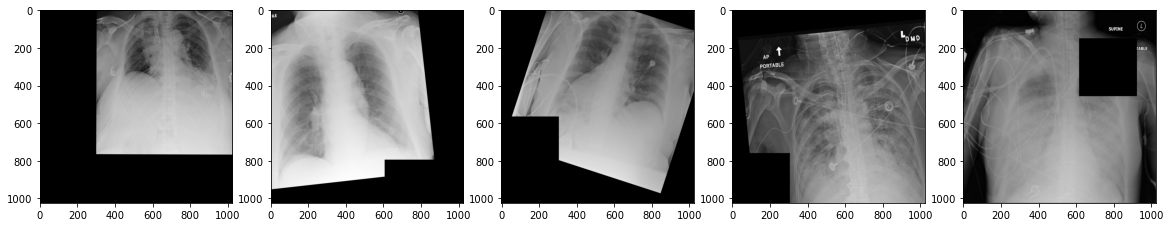

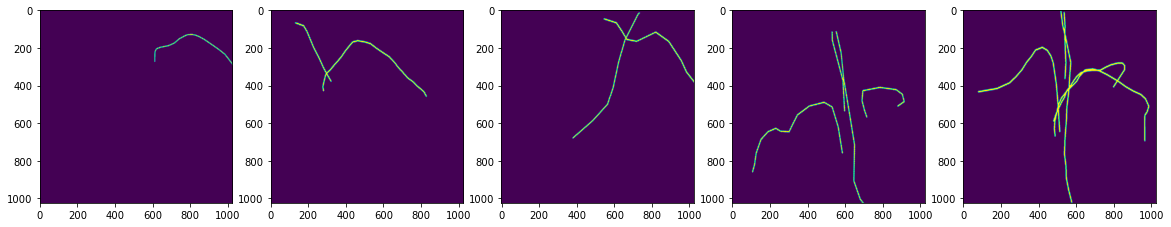

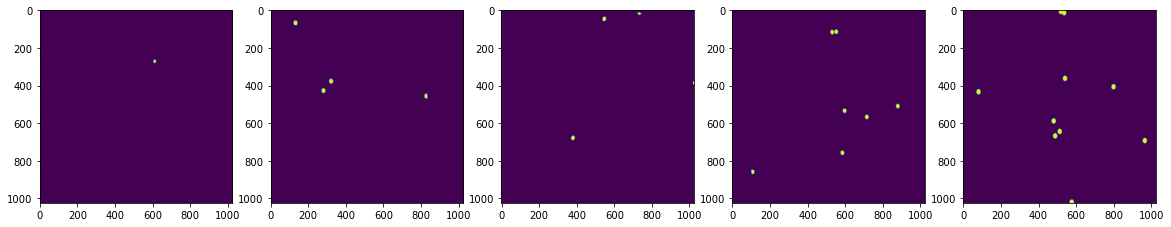

In [8]:
df_show = df_train.query('w_anno==True').iloc[:8]
dataset_show = RANZCRDataset(df_show, 'train', transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

f, axarr = plt.subplots(1,5)
masks = []
for p in range(5):
    img, mask = dataset_show[p]
    img[0] = img[0]
    axarr[p].imshow(img.transpose(0, 1).transpose(1,2))
    masks.append(mask)

f, axarr = plt.subplots(1,5)
for p in range(5):
    axarr[p].imshow(masks[p][0])

f, axarr = plt.subplots(1,5)
for p in range(5):
    axarr[p].imshow(masks[p][1])

# Model

In [9]:
class SegModel(nn.Module):
    def __init__(self, backbone):
        super(SegModel, self).__init__()
        self.seg = smp.UnetPlusPlus(encoder_name=backbone, encoder_weights='imagenet', classes=2, activation=None)
    def forward(self,x):
        global_features = self.seg.encoder(x)
        seg_features = self.seg.decoder(*global_features)
        seg_features = self.seg.segmentation_head(seg_features)
        return seg_features

m = SegModel(enet_type)
m(torch.rand(2,3,224,224)).shape

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_aa-ea7a6ee0.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_aa-ea7a6ee0.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

torch.Size([2, 2, 224, 224])

# Loss

In [10]:
criterion = nn.BCEWithLogitsLoss()

# LR Scheduler

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

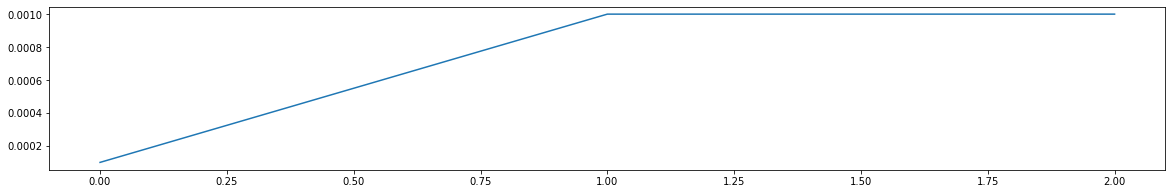

In [11]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

optimizer = optim.Adam(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

# Train & Valid Function

In [12]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, mask) in bar:

        optimizer.zero_grad()
        data, mask = data.to(device), mask.to(device)

        with amp.autocast():
            logits = model(data)
            loss = criterion(logits, mask)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_np = loss.item()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-50:]) / min(len(train_loss), 50)
        bar.set_description('loss: %.4f, smth: %.4f' % (loss_np, smooth_loss))

    return np.mean(train_loss)


def valid_epoch(model, loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    with torch.no_grad():
        for (data, mask) in tqdm(loader):
            data, mask = data.to(device), mask.to(device)
            logits = model(data)
            loss = criterion(logits, mask)
            val_loss.append(loss.item())
            LOGITS.append(logits.cpu())

    if get_output:
        LOGITS = torch.cat(LOGITS, 0).float().sigmoid()
        return LOGITS
    else:
        val_loss = np.mean(val_loss)
        return val_loss

# Run!

In [13]:
def run(fold):
    content = 'Fold: ' + str(fold)
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')
    train_ = df_train.query(f'w_anno==True and fold!={fold}').copy()
    valid_ = df_train.query(f'w_anno==True and fold=={fold}').copy()

    dataset_train = RANZCRDataset(train_, 'train', transform=transforms_train)
    dataset_valid = RANZCRDataset(valid_, 'valid', transform=transforms_val)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = SegModel(enet_type)
    model = model.to(device)
    val_loss_min = np.Inf
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')

    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss = valid_epoch(model, valid_loader)

        content = time.ctime() + ' ' + f'Fold {fold} Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {(val_loss):.5f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if val_loss_min > val_loss:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
            torch.save(model.state_dict(), model_file)
            val_loss_min = val_loss

In [14]:
for fold in range(5):
    run(fold)

Fold: 0
Fri Mar 19 02:09:55 2021 Epoch: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

Fri Mar 19 02:10:16 2021 Fold 0 Epoch 1, lr: 0.0001000, train loss: 0.80233, valid loss: 0.66612.
Validation loss decreased (inf --> 0.666123).  Saving model ...
Fri Mar 19 02:10:16 2021 Epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fri Mar 19 02:10:35 2021 Fold 0 Epoch 2, lr: 0.0010000, train loss: 0.62529, valid loss: 0.53721.
Validation loss decreased (0.666123 --> 0.537214).  Saving model ...
Fri Mar 19 02:10:35 2021 Epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fri Mar 19 02:10:54 2021 Fold 0 Epoch 3, lr: 0.0010000, train loss: 0.41343, valid loss: 0.61692.
Fold: 1
Fri Mar 19 02:10:54 2021 Epoch: 1


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fri Mar 19 02:11:13 2021 Fold 1 Epoch 1, lr: 0.0001000, train loss: 0.54452, valid loss: 0.67091.
Validation loss decreased (inf --> 0.670909).  Saving model ...
Fri Mar 19 02:11:13 2021 Epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fri Mar 19 02:11:31 2021 Fold 1 Epoch 2, lr: 0.0010000, train loss: 0.40087, valid loss: 0.43659.
Validation loss decreased (0.670909 --> 0.436585).  Saving model ...
Fri Mar 19 02:11:31 2021 Epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fri Mar 19 02:11:50 2021 Fold 1 Epoch 3, lr: 0.0010000, train loss: 0.25490, valid loss: 0.25928.
Validation loss decreased (0.436585 --> 0.259284).  Saving model ...
Fold: 2
Fri Mar 19 02:11:51 2021 Epoch: 1


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fri Mar 19 02:12:09 2021 Fold 2 Epoch 1, lr: 0.0001000, train loss: 0.86167, valid loss: 0.86767.
Validation loss decreased (inf --> 0.867668).  Saving model ...
Fri Mar 19 02:12:09 2021 Epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fri Mar 19 02:12:28 2021 Fold 2 Epoch 2, lr: 0.0010000, train loss: 0.72060, valid loss: 0.58444.
Validation loss decreased (0.867668 --> 0.584436).  Saving model ...
Fri Mar 19 02:12:28 2021 Epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fri Mar 19 02:12:47 2021 Fold 2 Epoch 3, lr: 0.0010000, train loss: 0.51766, valid loss: 0.53145.
Validation loss decreased (0.584436 --> 0.531446).  Saving model ...
Fold: 3
Fri Mar 19 02:12:48 2021 Epoch: 1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fri Mar 19 02:13:07 2021 Fold 3 Epoch 1, lr: 0.0001000, train loss: 0.99253, valid loss: 1.55773.
Validation loss decreased (inf --> 1.557731).  Saving model ...
Fri Mar 19 02:13:07 2021 Epoch: 2


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fri Mar 19 02:13:27 2021 Fold 3 Epoch 2, lr: 0.0010000, train loss: 0.76603, valid loss: 0.85306.
Validation loss decreased (1.557731 --> 0.853060).  Saving model ...
Fri Mar 19 02:13:27 2021 Epoch: 3


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fri Mar 19 02:13:47 2021 Fold 3 Epoch 3, lr: 0.0010000, train loss: 0.55400, valid loss: 0.37223.
Validation loss decreased (0.853060 --> 0.372229).  Saving model ...
Fold: 4
Fri Mar 19 02:13:48 2021 Epoch: 1


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 02:14:09 2021 Fold 4 Epoch 1, lr: 0.0001000, train loss: 0.60878, valid loss: 0.62722.
Validation loss decreased (inf --> 0.627221).  Saving model ...
Fri Mar 19 02:14:09 2021 Epoch: 2


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 02:14:30 2021 Fold 4 Epoch 2, lr: 0.0010000, train loss: 0.42577, valid loss: 0.38420.
Validation loss decreased (0.627221 --> 0.384198).  Saving model ...
Fri Mar 19 02:14:30 2021 Epoch: 3


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 02:14:51 2021 Fold 4 Epoch 3, lr: 0.0010000, train loss: 0.24061, valid loss: 0.16811.
Validation loss decreased (0.384198 --> 0.168114).  Saving model ...


# Generate Mask

In [15]:
output_dir = f'mask_{kernel_type}'
os.makedirs(output_dir, exist_ok=True)

In [16]:
# Part 1, generate mask for those images with annotations. To prevent leaks, use only the model corresponding to the fold
for fold in range(5):
    valid_ = df_train.query(f'w_anno==True and fold=={fold}').copy()
    dataset_valid = RANZCRDataset(valid_, 'valid', transform=transforms_val)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = SegModel(enet_type)
    model = model.to(device)
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')
    model.load_state_dict(torch.load(model_file), strict=False)
    model.eval()
    
    outputs = valid_epoch(model, valid_loader, get_output=True).numpy()

    for i, (_, row) in tqdm(enumerate(valid_.iterrows())):
        png = (outputs[i] * 255).astype(np.uint8).transpose(1,2,0)
        # add a channel to make it able to be saved as .png
        png = np.concatenate([png, np.zeros((png.shape[0], png.shape[1], 1))], -1)
        cv2.imwrite(os.path.join(output_dir, f'{row.StudyInstanceUID}.png'), png)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [17]:
# Part 2, For those images without annotations, use 5-fold models to predict and take the mean value
df_train_wo_anno = df_train.query(f'w_anno==False').copy().reset_index(drop=True)
dataset_test = RANZCRDataset(df_train_wo_anno, 'test', transform=transforms_val)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

models = []
for fold in range(5):
    model = SegModel(enet_type)
    model = model.to(device)
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')
    model.load_state_dict(torch.load(model_file), strict=False)
    model.eval()
    models.append(model)

with torch.no_grad():
    for batch_id, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        data = data.to(device)
        outputs = torch.stack([model(data).sigmoid() for model in models], 0).mean(0).cpu().numpy()
        for i in range(outputs.shape[0]):
            row = df_train_wo_anno.loc[batch_id*batch_size + i]
            png = (outputs[i] * 255).astype(np.uint8).transpose(1,2,0)
            # add a channel to make it able to be saved as .png
            png = np.concatenate([png, np.zeros((png.shape[0], png.shape[1], 1))], -1)
            cv2.imwrite(os.path.join(output_dir, f'{row.StudyInstanceUID}.png'), png)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
!zip -r -q pred_masks.zip {output_dir}

In [19]:
!rm -rf {output_dir}

In [20]:
ls

__notebook__.ipynb  logs/  models/  pred_masks.zip


# Appendix: My Local Training Log Fold 0

You should get similar log to mine only by changing `DEBUG = False` and train on your local machine with >= 16GB GPU.


```
Wed Mar 17 01:08:11 2021 Fold 0 Epoch 1, lr: 0.0001000, train loss: 0.08337, valid loss: 0.01769.
Wed Mar 17 01:28:57 2021 Fold 0 Epoch 2, lr: 0.0010000, train loss: 0.01330, valid loss: 0.01110.
Wed Mar 17 01:49:42 2021 Fold 0 Epoch 3, lr: 0.0010000, train loss: 0.01107, valid loss: 0.01013.
Wed Mar 17 02:10:28 2021 Fold 0 Epoch 4, lr: 0.0009883, train loss: 0.01042, valid loss: 0.00958.
Wed Mar 17 02:31:13 2021 Fold 0 Epoch 5, lr: 0.0009738, train loss: 0.01002, valid loss: 0.00989.
Wed Mar 17 02:51:57 2021 Fold 0 Epoch 6, lr: 0.0009538, train loss: 0.00971, valid loss: 0.00918.
Wed Mar 17 03:12:41 2021 Fold 0 Epoch 7, lr: 0.0009284, train loss: 0.00949, valid loss: 0.00925.
Wed Mar 17 03:33:25 2021 Fold 0 Epoch 8, lr: 0.0008980, train loss: 0.00924, valid loss: 0.00898.
Wed Mar 17 03:54:11 2021 Fold 0 Epoch 9, lr: 0.0008630, train loss: 0.00912, valid loss: 0.00887.
Wed Mar 17 04:14:57 2021 Fold 0 Epoch 10, lr: 0.0008237, train loss: 0.00890, valid loss: 0.00857.
Wed Mar 17 04:35:42 2021 Fold 0 Epoch 11, lr: 0.0007806, train loss: 0.00879, valid loss: 0.00856.
Wed Mar 17 04:56:25 2021 Fold 0 Epoch 12, lr: 0.0007342, train loss: 0.00871, valid loss: 0.00839.
Wed Mar 17 05:17:10 2021 Fold 0 Epoch 13, lr: 0.0006851, train loss: 0.00853, valid loss: 0.00836.
Wed Mar 17 05:37:53 2021 Fold 0 Epoch 14, lr: 0.0006338, train loss: 0.00845, valid loss: 0.00840.
Wed Mar 17 05:58:37 2021 Fold 0 Epoch 15, lr: 0.0005809, train loss: 0.00827, valid loss: 0.00821.
Wed Mar 17 06:19:23 2021 Fold 0 Epoch 16, lr: 0.0005271, train loss: 0.00821, valid loss: 0.00814.
Wed Mar 17 06:40:07 2021 Fold 0 Epoch 17, lr: 0.0004729, train loss: 0.00813, valid loss: 0.00824.
Wed Mar 17 07:00:51 2021 Fold 0 Epoch 18, lr: 0.0004191, train loss: 0.00809, valid loss: 0.00808.
Wed Mar 17 07:21:37 2021 Fold 0 Epoch 19, lr: 0.0003662, train loss: 0.00794, valid loss: 0.00801.
Wed Mar 17 07:42:21 2021 Fold 0 Epoch 20, lr: 0.0003149, train loss: 0.00783, valid loss: 0.00798.
Wed Mar 17 08:03:05 2021 Fold 0 Epoch 21, lr: 0.0002658, train loss: 0.00782, valid loss: 0.00797.
Wed Mar 17 08:23:52 2021 Fold 0 Epoch 22, lr: 0.0002194, train loss: 0.00768, valid loss: 0.00790.
Wed Mar 17 08:44:36 2021 Fold 0 Epoch 23, lr: 0.0001763, train loss: 0.00765, valid loss: 0.00794.
Wed Mar 17 09:05:20 2021 Fold 0 Epoch 24, lr: 0.0001370, train loss: 0.00756, valid loss: 0.00788.
Wed Mar 17 09:26:06 2021 Fold 0 Epoch 25, lr: 0.0001020, train loss: 0.00758, valid loss: 0.00789.
Wed Mar 17 09:46:58 2021 Fold 0 Epoch 26, lr: 0.0000716, train loss: 0.00750, valid loss: 0.00784.
Wed Mar 17 10:07:39 2021 Fold 0 Epoch 27, lr: 0.0000462, train loss: 0.00745, valid loss: 0.00786.
Wed Mar 17 10:28:26 2021 Fold 0 Epoch 28, lr: 0.0000262, train loss: 0.00743, valid loss: 0.00786.
Wed Mar 17 10:49:13 2021 Fold 0 Epoch 29, lr: 0.0000117, train loss: 0.00746, valid loss: 0.00784.
Wed Mar 17 11:09:55 2021 Fold 0 Epoch 30, lr: 0.0000029, train loss: 0.00741, valid loss: 0.00785.
```